In [1]:
# Import Necessary Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from scipy.stats import randint

First few rows of the dataset:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Missing Values per Column:
RowNumber          0
CustomerId         0
Su

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


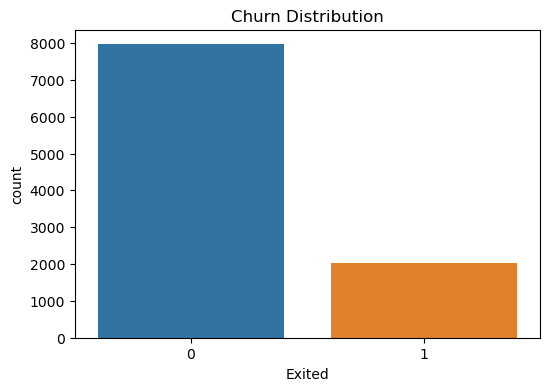

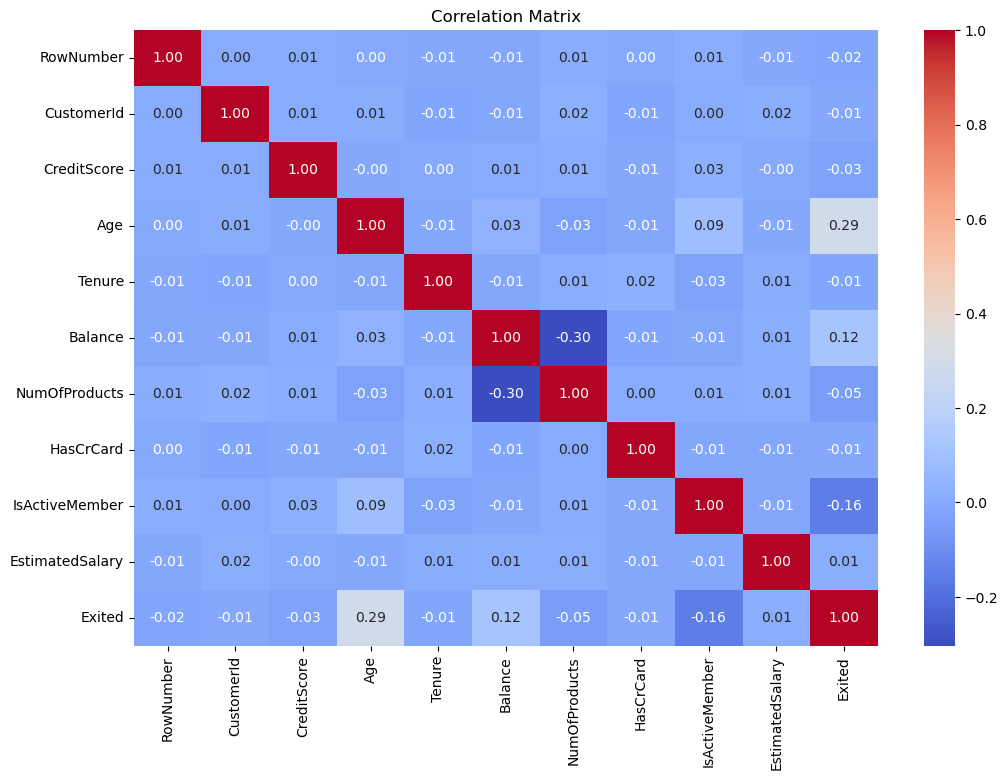

In [2]:
# Load and Explore Data 
data = pd.read_csv(r'C:\Users\Sosa the chief\Downloads\Churn_Modelling.csv')
print("First few rows of the dataset:")
display(data.head())
print("\nDataset Information:")
data.info()
print("\nMissing Values per Column:")
print(data.isnull().sum())
print("\nStatistical Summary for Numerical Columns:")
display(data.describe())

# Visualize Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=data)
plt.title('Churn Distribution')
plt.show()

# Correlation Analysis
numeric_data = data.select_dtypes(include=['number'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Data Preprocessing
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)

X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Handle Class Imbalance 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [3]:
# Baseline Model Training and Evaluation 

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results.append({
        "Model": name,
        "Recall": report["1"]["recall"],
        "Precision": report["1"]["precision"],
        "F1-Score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model    Recall  Precision  F1-Score  ROC-AUC
0  Logistic Regression  0.664122   0.385524  0.487850  0.76832
1        Random Forest  0.608142   0.594527  0.601258  0.85204
2              XGBoost  0.564885   0.623596  0.592790  0.85209


In [10]:
# Further evaluation of standard Random Forest 
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.76      0.46      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000


Confusion Matrix:
[[1551   56]
 [ 211  182]]

ROC-AUC Score: 0.8572


In [11]:
# Hyperparameter Tuning for Random Forest 
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
random_search.fit(X_train_resampled, y_train_resampled)
best_rf_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 382}


In [12]:
# Train and Report Tuned Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Tuned parameters (found via RandomizedSearchCV)
rf_tuned = RandomForestClassifier(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=382,
    random_state=42
)

# Train the model with the sampled SMOTE-trainingsset
rf_tuned.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_tuned.predict(X_test)
y_pred_proba = rf_tuned.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1607
           1       0.60      0.62      0.61       393

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.85      0.84      0.84      2000


Confusion Matrix:
[[1445  162]
 [ 151  242]]

ROC-AUC Score: 0.8537


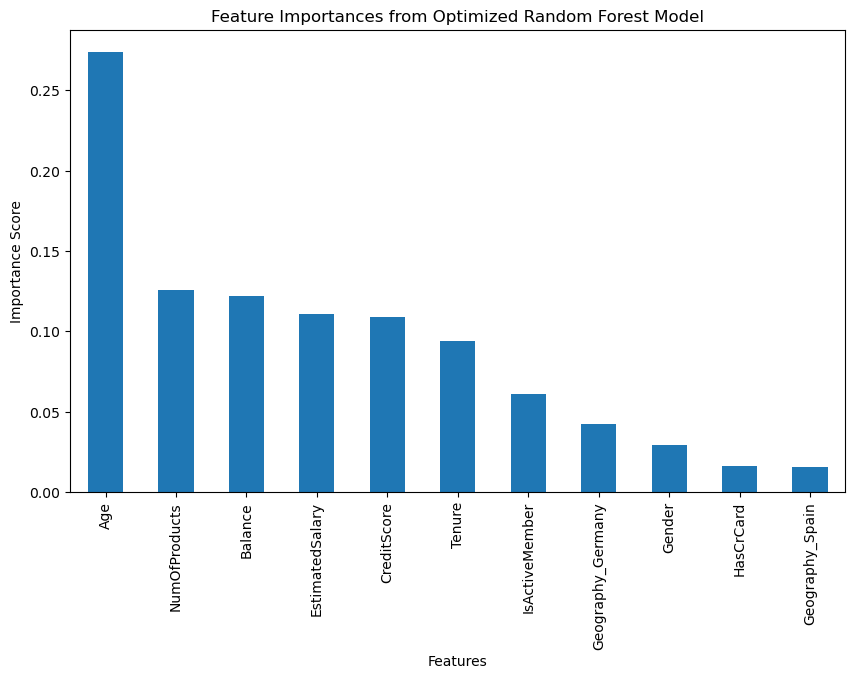

In [5]:
# Feature Importance Analysis 
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Feature Importances from Optimized Random Forest Model")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


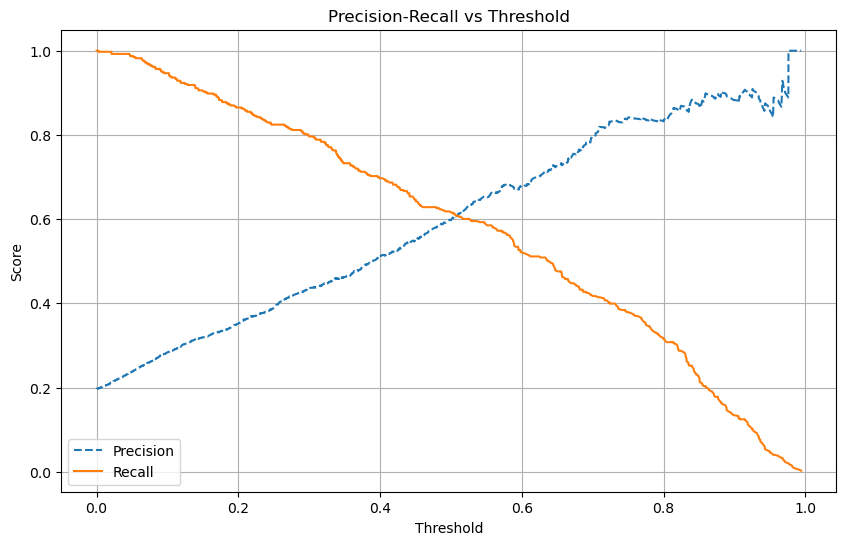

In [7]:
# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], linestyle='--', label="Precision")
plt.plot(thresholds, recalls[:-1], linestyle='-', label="Recall")
plt.title("Precision-Recall vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()



In [8]:
# Cross-Validation 
cv_scores = cross_val_score(best_rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", cv_scores)
print("Mean AUC score:", cv_scores.mean())


Cross-validated AUC scores: [0.92641763 0.96212714 0.97488054 0.97102432 0.97884571]
Mean AUC score: 0.9626590707542022
